In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd

# In Anaconda -> Environments -> Not Installed -> pandas-datareader -> Apply
from pandas_datareader import data as web # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go

# Make Plotly work in your Jupyter Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# Use Plotly locally
cf.go_offline()

import warnings
warnings.simplefilter("ignore")

# pip install yfinance in Qt Console or Powershell Prompt on Windows
import yfinance as yf

from plotly.subplots import make_subplots

# Install the Python Technical Analysis library
# pip install ta in Qt Console or Powershell prompt
from ta.trend import MACD
from ta.momentum import StochasticOscillator

## Download Stock Data

In [2]:
amd_df = yf.download(tickers="AMD", period="1y", interval='1d')
amd_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-03,94.059998,94.699997,92.010002,92.309998,92.309998,35859700
2020-12-04,92.580002,94.580002,90.629997,94.040001,94.040001,45570300
2020-12-07,94.949997,95.000000,92.970001,94.070000,94.070000,39815700
2020-12-08,94.050003,94.739998,91.900002,92.919998,92.919998,33907500
2020-12-09,92.760002,94.699997,89.160004,89.830002,89.830002,52170400
...,...,...,...,...,...,...
2021-11-26,155.800003,158.100006,152.809998,154.809998,154.809998,36245100
2021-11-29,157.500000,162.509995,156.100006,161.910004,161.910004,57438900
2021-11-30,163.279999,164.460007,155.679993,158.369995,158.369995,75182500


## Exponential Moving Average

A EMA allows you to see the big picture when analyzing a stock. Unlike the Simple Moving Average it reduces the lag by putting more emphasis on recent price data.

In [3]:
amd_df['MA20'] = amd_df['Adj Close'].ewm(span=20, adjust=False).mean()
amd_df['MA50'] = amd_df['Adj Close'].ewm(span=50, adjust=False).mean()
amd_df

,Open,High,Low,Close,Adj Close,Volume,MA20,MA50
Date,,,,,,,,
2020-12-03,94.059998,94.699997,92.010002,92.309998,92.309998,35859700,92.309998,92.309998
2020-12-04,92.580002,94.580002,90.629997,94.040001,94.040001,45570300,92.474760,92.377841
2020-12-07,94.949997,95.000000,92.970001,94.070000,94.070000,39815700,92.626687,92.444200
2020-12-08,94.050003,94.739998,91.900002,92.919998,92.919998,33907500,92.654622,92.462859
2020-12-09,92.760002,94.699997,89.160004,89.830002,89.830002,52170400,92.385610,92.359609
...,...,...,...,...,...,...,...,...
2021-11-26,155.800003,158.100006,152.809998,154.809998,154.809998,36245100,144.445907,129.557166
2021-11-29,157.500000,162.509995,156.100006,161.910004,161.910004,57438900,146.109154,130.825905
2021-11-30,163.279999,164.460007,155.679993,158.369995,158.369995,75182500,147.276853,131.906065


## Plotting Moving Averages

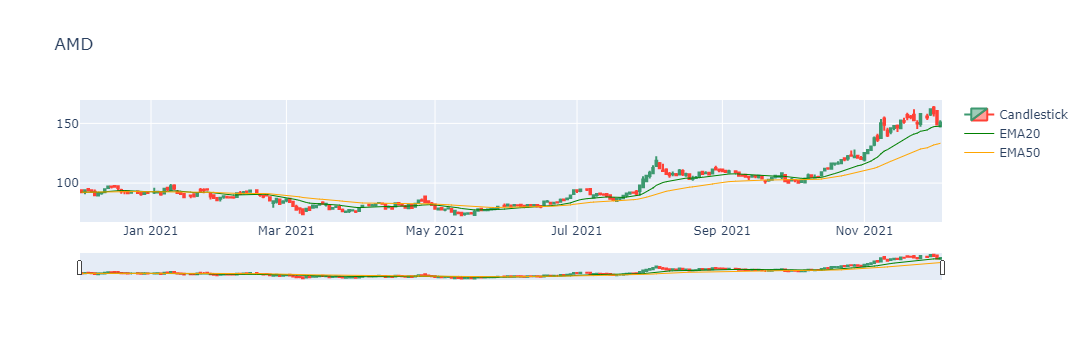

In [4]:
fig = go.Figure()

# Define candlestick and moving average lines
candle = go.Candlestick(x=amd_df.index, open=amd_df['Open'],
                       high=amd_df['High'], low=amd_df['Low'],
                       close=amd_df['Close'], name='Candlestick')
ema20 = go.Scatter(x=amd_df.index, y=amd_df['MA20'], 
                   line=dict(color='green', width=1), name="EMA20")

ema50 = go.Scatter(x=amd_df.index, y=amd_df['MA50'], 
                  line=dict(color='orange', width=1), name="EMA50")

# Add plots to the figure
fig.add_trace(candle)
fig.add_trace(ema20)
fig.add_trace(ema50)      

# Add title
fig.update_layout(title="AMD")

# Get rid of empty dates on the weekend
fig.update_xaxes(rangebreaks=[dict(bounds=["sat", "mon"])])
                                            
fig.show()

## Moving Average Convergence & Divergence

The MACD helps us to see buy & sell signals. It shows the difference between 2 moving averages.

While these signals are derived from moving averages they occur much more quickly then with moving averages. It is important to know that since the signals occur earlier that they are also more risky. 

When the signal line crosses the MACD line moving upwards this is bullish and vice versa. The slope of the angle tells you how strong the trend is. 

In [5]:
def plot_macd_stoch(ticker, time_period, time_int):
    # Download stock data
    stock_df = yf.download(tickers=ticker, period=time_period, interval=time_int)
    
    # Define candlestick and moving average lines
    candle = go.Candlestick(x=stock_df.index, open=stock_df['Open'],
                       high=stock_df['High'], low=stock_df['Low'],
                       close=stock_df['Close'])
    # A period of 12 and 26 are commonly used
    stock_df['MA12'] = stock_df['Adj Close'].ewm(span=12, adjust=False).mean()
    stock_df['MA26'] = stock_df['Adj Close'].ewm(span=26, adjust=False).mean()
    
    # Calculate the MACD
    # A signal line uses a period of 9 and when it crosses the other moving
    # average it is a sign to buy or sell
    macd = MACD(close=stock_df['Close'],
             window_slow=26,
             window_fast=12,
             window_sign=9)

    # A Stochastic (stuh ka stuhk) Oscillator is also plotted because it 
    # gives us a signal of an upcoming trend reversal
    # Values range from 0 to 100 and values over 80 are considered to be
    # overbought while those under 20 are considered oversold
    
    # We calculate normally over a 14 day period
    # We are smoothing price data
    sto_os = StochasticOscillator(high=stock_df['High'],
                             close=stock_df['Close'],
                             low=stock_df['Low'],
                             window=14, 
                             smooth_window=3)
    
    # Make 4 subplots on separate rows
    fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.01)

    fig.add_trace(candle, row=1, col=1)

    # Add the histogram, MACD and Signal lines
    
    # The MacD line is a calculation made by subtracting the 26 period
    # EMA from the 12 period EMA
    fig.add_trace(go.Scatter(x=stock_df.index,
                         y=macd.macd(),
                         line=dict(color='blue', width=2)
                        ), row=2, col=1)
    
    # The signal is calculated by taking the average of the last 9 values
    # of the MACD line (The signal line is a slower more smoothed out version of
    # the MACD line)
    fig.add_trace(go.Scatter(x=stock_df.index,
                         y=macd.macd_signal(),
                         line=dict(color='orange', width=2)
                        ), row=2, col=1)
    
    # The histogram shows the difference between the MACD and signal line
    # When the MACD line is below the signal that is a negative value and vice versa
    fig.add_trace(go.Bar(x=stock_df.index, 
                     y=macd.macd_diff()
                    ), row=2, col=1)
    
    # The MacD line is a calculation made by subtracting the 26 period
    # EMA from the 12 period EMA
    fig.add_trace(go.Scatter(x=stock_df.index,
                         y=macd.macd(),
                         line=dict(color='blue', width=2)
                        ), row=2, col=1)
    
    # The signal is calculated by taking the average of the last 9 values
    # of the MACD line (The signal line is a slower more smoothed out version of
    # the MACD line)
    fig.add_trace(go.Scatter(x=stock_df.index,
                         y=macd.macd_signal(),
                         line=dict(color='orange', width=2)
                        ), row=2, col=1)

    # Plot Stochastics
    # This is the faster of the 2 lines called the K line
    fig.add_trace(go.Scatter(x=stock_df.index,
                         y=sto_os.stoch(),
                         line=dict(color='blue', width=2)
                        ), row=3, col=1)
    # This line is slower and is known as the D line and it is an average of the K line
    fig.add_trace(go.Scatter(x=stock_df.index,
                         y=sto_os.stoch_signal(),
                         line=dict(color='orange', width=2)
                        ), row=3, col=1)
    
    # Draw 20 and 80 lines
    fig.add_hline(y=20, line_width=1, line_dash="dash", line_color="red", row=3, col=1)
    fig.add_hline(y=80, line_width=1, line_dash="dash", line_color="green", row=3, col=1)

    # Add volume 
    fig.add_trace(go.Bar(x=stock_df.index, 
                     y=stock_df['Volume']
                    ), row=4, col=1)

    # Update titles
    fig.update_layout(title=ticker)
    fig.update_yaxes(title_text="Price", row=1, col=1)
    fig.update_yaxes(title_text="MACD", row=2, col=1)
    fig.update_yaxes(title_text="StoOs", row=3, col=1)
    fig.update_yaxes(title_text="Volume", row=4, col=1)

    fig.update_layout(height=900, width=1200, 
                  showlegend=False, 
                  xaxis_rangeslider_visible=False,
                  xaxis_rangebreaks=[dict(bounds=["sat", "mon"]), dict(bounds=[16, 9.5], pattern="hour")])

    fig.show()

[*********************100%***********************]  1 of 1 completed


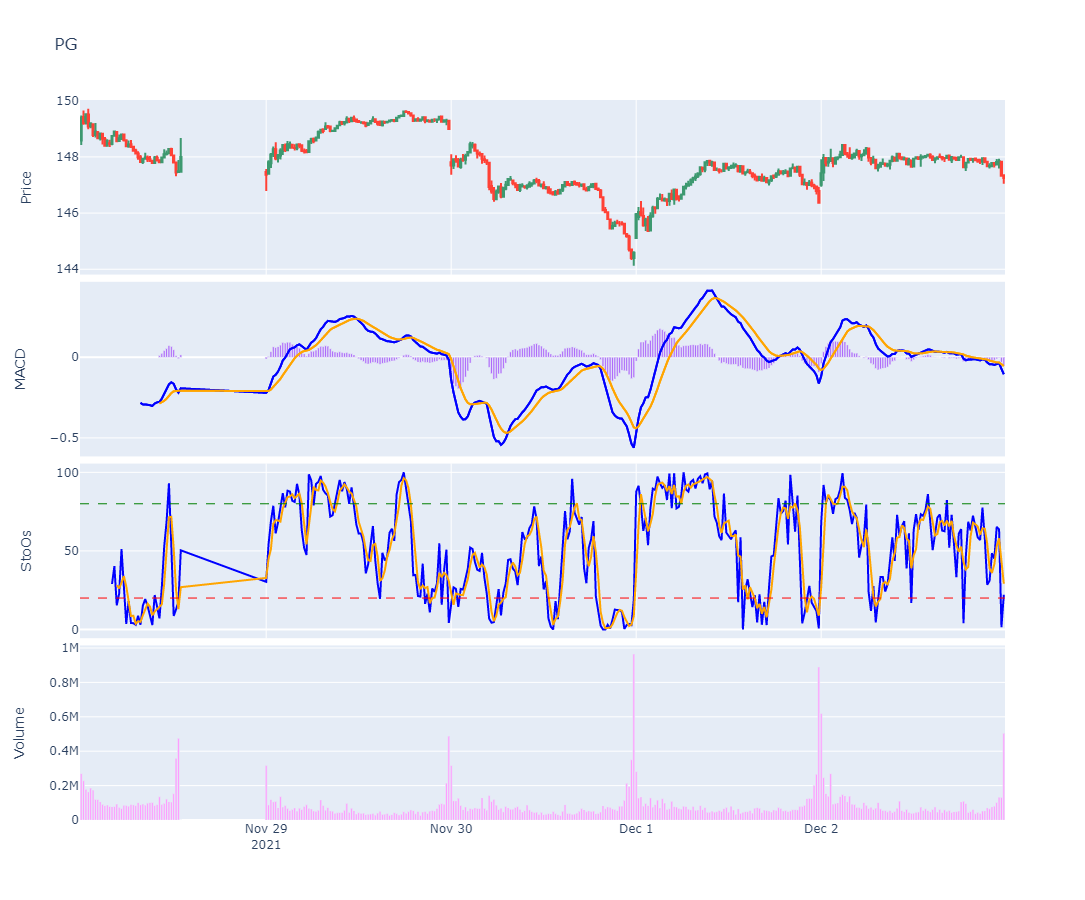

In [8]:
# If we plot PG we can see a resistance line at around 140 on multiple dates
# The volumes spike leading into uptrends
# plot_macd_stoch("PG", "2mo", "1h")

# Now we will zoom in and we can see how when the MACD crosses over that these are potential 
# opportunities to buy or sell (This example would work better if we were near 140)
plot_macd_stoch("PG", "5d", "5m")

# A Stochastic (stuh ka stuhk) Oscillator is also plotted because it 
# gives us a signal of an upcoming trend reversal
# Values range from 0 to 100 and values over 80 are considered to be
# overbought while those under 20 are considered oversold
# This isn't a simple buy or sell plot however and it is common for stocks
# to stay overbought or sold over long periods
# This isn't a chart you use on its own, but instead to backup other charts
# You use it normally when an investment is either in a down or up trend.
# This means the stock is bouncing up and down, but consistently reaching higher highs
# or lower lows. When in one of these trends it is common for it to remain in
# overbought or sold trends for a long time.

# Don't buy based on this chart during downtrends and don't sell during uptrends!